In [1]:
import numpy as np
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt
from scipy.sparse.sputils import isshape
import cvxpy as cp
import scipy as sp

In [2]:
class SparseMatrix:
    __array_priority__ = 1
    
    def __init__(self, A):
        if isinstance(A, np.ndarray):
            nonzero_ind = np.nonzero(A)
            self.values = A[nonzero_ind]
            self.rows = nonzero_ind[0]
            self.cols = nonzero_ind[1]
            self.shape = A.shape
            return
        if isinstance(A, tuple):
            self.values, self.rows, self.cols, self.shape = A
            return
        raise TypeError("Unknokn type in __init__")
        
    def __mul__(self, v):
        assert isinstance(v, np.ndarray)
        if self.shape[1] != v.size:
            raise ValueError("Dimensions don't match")
            
        ans = np.zeros(self.shape[0])
        for val, r, c in zip(self.values, self.rows, self.cols):
            ans[r] += val * v[c]
        return ans
    
    def transpose(self):
        return SparseMatrix((self.values, self.cols, self.rows, (self.shape[1], self.shape[0])))
    
    def __rmul__(self, v):
        assert isinstance(v, np.ndarray)
        if v.size != self.shape[0]:
            raise ValueError("Dimensions don't match")
            
        ans = np.zeros(self.shape[1])
        for val, r, c in zip(self.values, self.rows, self.cols):
            ans[c] += val * v[r]
        return ans

In [3]:
def test_matrix():
    for i in range(10):
        shape = (np.random.randint(1, 10), np.random.randint(1, 10))
        A = np.random.randn(shape[0], shape[1])
        v = np.random.randn(shape[1])
        assert_allclose(np.dot(A, v), SparseMatrix(A) * v)
        u = np.random.randn(shape[0])
        assert_allclose(np.dot(u, A), u * SparseMatrix(A))
        
test_matrix()

Т.к. $||Ax - b||^2 = <Ax - b, Ax - b> = x^TA^TAx - 2b^TAx + b^Tb$, будем минимизировать функцию $f(x) = \frac{1}{2}x^TA^TAx - b^TAx$.

In [4]:
def conjugate_gradient(A, b, x_0):
    x = x_0
    A = SparseMatrix(A)
    A_T = A.transpose()
    v = A_T * (A * x) - b * A
    d = v
    v_norm = np.dot(v, v)
    
    result = [x.copy()]
    for i in range(len(b)):
        Ad = A_T * (A * d)
        alpha = v_norm / np.dot(d, Ad)
        x = x - alpha * d
        v = v - alpha * Ad
        v_norm_new = np.dot(v, v)

        d = v + (v_norm_new / v_norm) * d
        v_norm = v_norm_new
        result.append(x.copy())
    return result

In [5]:
def show_cgd():
    A = np.random.rand(5, 5)
    A = A @ A.T
    sD = sp.linalg.sqrtm(np.linalg.inv(np.diag(np.diag(A))))
    A = sD.T @ A @ sD
    
    b = np.random.rand(5)
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    x = np.zeros_like(b)
    
    estimates_conjugate_gradient = conjugate_gradient(A, b, x)
    
    axs.plot([i for i in range(len(estimates_conjugate_gradient))], [np.linalg.norm(A @ x - b) for x in estimates_conjugate_gradient], label='CGD')
    axs.legend()
    axs.set_ylabel(r'$\|Ax_k-b\|$', fontsize=20)
    axs.set_xlabel(r'$k$', fontsize=20)
    axs.set_yscale('log')
    plt.close(fig)
    return fig

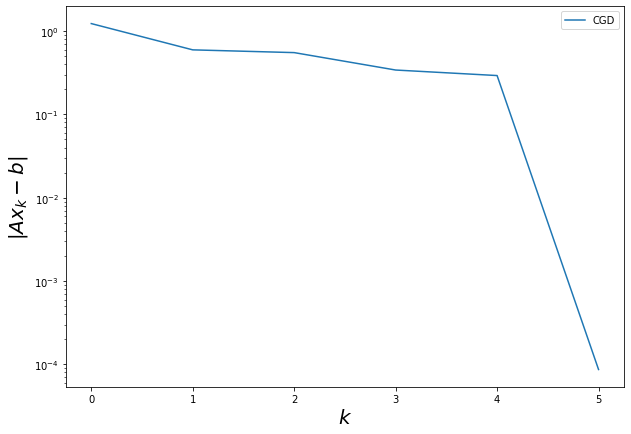

In [6]:
show_cgd()